In [2]:
import pyarrow.parquet as pq
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# 忽略所有警告
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体，或者使用你系统上可用的其他字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [ ]:
table = pd.read_parquet("ag")

In [53]:
table['current_volume'] = table['Volume'].diff()
table['Position Increase'] = table['OpenInterest'].diff()
table['current_turnover'] = table['Turnover'].diff()
table['current_avg_price'] = table['current_turnover']/(table['current_volume']*15)


In [54]:
table.loc[(table['current_volume'] == table['Position Increase']) & (table['Position Increase'] > 0),'开平方向'] = '双开'
table.loc[(table['current_volume'] > table['Position Increase']) & (table['Position Increase'] > 0),'开平方向'] = '开仓'
table.loc[(table['current_volume'] > -table['Position Increase']) & (-table['Position Increase'] > 0),'开平方向'] = '平仓'
table.loc[(table['current_volume'] > table['Position Increase']) & (table['Position Increase'] == 0),'开平方向'] = '换手'
table.loc[table['current_volume'] == -table['Position Increase'],'开平方向'] = '双平'
table.loc[(table['current_volume'] == table['Position Increase']) & (table['Position Increase'] == 0),'开平方向'] = '未知'

In [55]:
#判断是否主动买卖
table['主动买or主动卖'] = '被动买卖'
table.loc[table['last'] >= table['AskPrice1'].shift(1),'主动买or主动卖'] = '主动买'
table.loc[table['last'] <= table['BidPrice1'].shift(1),'主动买or主动卖'] = '主动卖'


In [56]:
#这500ms中成交的价格对为Low Price和High Price（假设只有两个价格成交，这里的价格对指的是当期的价格）
table['Low Price比例'] = (table['current_avg_price'] - table['AskPrice1'])/(table['BidPrice1'] - table['AskPrice1'])
table['High Price比例'] = 1 - table['Low Price比例']
#'High Price比例'反映高价交易的成交比例；'Low Price比例'反映低价交易的成交比例
#主动买：当High Price比例大于1时，说明交易以超过卖一价达成，即交易的买一价可能是卖二、卖三，反映市场的看多力量；如果出现Low Price比例大于1，可能是因为出现大单，在切片时间段内价格持续快速上涨，导致此时的买二价可能是原来的卖二、卖三等
#主动卖：当Low Price比例大于1时，说明交易以低于买一价达成，即交易的卖一价可能是买二、买三，反映市场的看空力量；如果出现High Price比例大于1，也可能是因为出现大单，在切片时间段内价格持续快速下跌，导致此时的卖二价可能是原来的买二、买三等

In [57]:
#大部分数据的成交价格为500ms时的卖一和买一（这是因为时间足够短，不存在大的价格变化）
table['成交价格对'] = 'BidPrice1 and AskPrice1'
table.loc[(table['High Price比例'] > 1),'成交价格对'] = 'AskPrice1 and AskPrice2'#如果是主动买，正常；如果是主动卖，可能出现当期买一价和卖一价相较于上一期出现较大变化，当期的AskPrice1 and AskPrice2可能是上一期的买二、买三、买四
table.loc[(table['Low Price比例'] > 1),'成交价格对'] = 'BidPrice2 and BidPrice1'#如果是主动卖，正常；如果是主动买，可能出现当期买一价和卖一价相较于上一期出现较大变化，当期的BidPrice2 and BidPrice1可能是上一期的卖二、卖三、卖四
table['Low Price比例'].loc[(table['High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice2'])/(table['AskPrice1'] - table['AskPrice2'])
table['Low Price比例'].loc[(table['Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice1'])/(table['BidPrice2'] - table['BidPrice1'])
table.loc[(table['Low Price比例'] > 1),'成交价格对'] = 'BidPrice3 and BidPrice2'
table['Low Price比例'].loc[(table['Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice2'])/(table['BidPrice3'] - table['BidPrice2'])
table.loc[(table['Low Price比例'] > 1),'成交价格对'] = 'BidPrice3 and BidPrice4'#这里的买三买四实际上是上一期的卖三卖四，出现这个现象的原因是大单成交，导致价格剧烈波动
table['Low Price比例'].loc[(table['Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice3'])/(table['BidPrice4'] - table['BidPrice3'])
table['High Price比例'] = 1-table['Low Price比例']





In [58]:
table['前一期成交价格对'] = 'BidPrice1 and AskPrice1'
table['前一期Low Price比例'] = (table['current_avg_price'] - table['AskPrice1'].shift(1))/(table['BidPrice1'].shift(1) - table['AskPrice1'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice1 and AskPrice2'
table.loc[(table['前一期Low Price比例'] > 1),'前一期成交价格对'] = 'BidPrice2 and BidPrice1'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice2'].shift(1))/(table['AskPrice1'].shift(1) - table['AskPrice2'].shift(1))
table['前一期Low Price比例'].loc[(table['前一期Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice1'].shift(1))/(table['BidPrice2'].shift(1) - table['BidPrice1'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice2 and AskPrice3'
table.loc[(table['前一期Low Price比例'] > 1),'前一期成交价格对'] = 'BidPrice3 and BidPrice2'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice3'].shift(1))/(table['AskPrice2'].shift(1) - table['AskPrice3'].shift(1))
table['前一期Low Price比例'].loc[(table['前一期Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice2'].shift(1))/(table['BidPrice3'].shift(1) - table['BidPrice2'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice3 and AskPrice4'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice4'].shift(1))/(table['AskPrice3'].shift(1) - table['AskPrice4'].shift(1))
table['前一期High Price比例'] = 1-table['前一期Low Price比例']


1、507条数据出现成交价格不在当期切片的卖一和买一之间，出现这一现象的可能原因是出现大单导致价格发生大幅度变化；\
2、还有可能是前一期出现大单导致人们的期望发生变化，导致出现持续的价格下跌或者价格上涨；\
3、在某一时刻成交量很低，成交价格并不是买一价和卖一价这个价格对。

In [60]:
#df = table.loc[table['成交价格对'] != table['前一期成交价格对']]
#df

In [1]:
table.iloc[3595:3600]

NameError: name 'table' is not defined

# 因子构造
利用当期数据构造因子：\
1、主动买则释放价格上升的信号；\
2、由于我们用的是当期卖一价和买一价计算High Price 和 Low Price比例，猜测卖一价（High Price）比例高则成交价有上升趋势，买一价（Low Price）比例高则成交价有下降趋势。\
3、利用成交的价格对来判断：都通过买价成交，那说明价格剧烈波动，出现上涨趋势；都通过卖价成交，那说明价格剧烈波动，出现下跌趋势。二三似乎有一定的矛盾，假设都以卖一价和买一价计算成交比例，那么如果都通过买价成交，即买一价的成交比例大于1，此时成交价应该有下降趋势，但上面的分析说明都通过买价成交的话，价格应该出现上涨趋势。（但也有可能在剧烈的价格波动后价格出现回归的现象）\
利用前一期数据构造因子似乎更加合理。

一些成功因子的实践

In [62]:
def cal_return(fct,ret):
    # fct是因子值，ret是未来1个周期的收益率
    fct_ret = fct * ret
    # 累加
    nav = fct_ret.cumsum()
    return nav

In [63]:
def price_versus_avg(df):
    # 成交价减去平均价
    fct = df['last'] - df['current_avg_price']
    fct.dropna(inplace=True)
    return fct

In [64]:
"""ret = table['change_rate'].diff().dropna()
alpha = price_versus_avg(table)
correlation = ret.corr(alpha)
print(f"相关系数: {correlation}")
nav_return = cal_return(price_versus_avg(table),ret)

plt.figure(figsize=(10, 6))
plt.plot(nav_return, label='因子收益率', color='b')
plt.title('因子收益率图', fontsize=16)
plt.xlabel('时间', fontsize=14)
plt.ylabel('累计净值', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()"""

'ret = table[\'change_rate\'].diff().dropna()\nalpha = price_versus_avg(table)\ncorrelation = ret.corr(alpha)\nprint(f"相关系数: {correlation}")\nnav_return = cal_return(price_versus_avg(table),ret)\n\nplt.figure(figsize=(10, 6))\nplt.plot(nav_return, label=\'因子收益率\', color=\'b\')\nplt.title(\'因子收益率图\', fontsize=16)\nplt.xlabel(\'时间\', fontsize=14)\nplt.ylabel(\'累计净值\', fontsize=14)\nplt.legend()\nplt.grid(True)\nplt.show()'

In [65]:
#利用AskPrice1和BidPrice1计算价格的平均值，进而计算分钟频的收益率
def mid_price(df):
    mid = (df['AskPrice1'] + df['BidPrice1'])/2
    mid = mid.astype(float)
    return mid

table['return'] = -mid_price(table).pct_change(-120)


In [66]:
#构造因子
#因子1：主动买or主动卖
table['factor1'] = 0
table['factor1'].loc[table['主动买or主动卖'] == '主动买'] = 1
table['factor1'].loc[table['主动买or主动卖'] == '主动卖'] = -1


In [67]:
#因子2：前一期成交价格比例
#table['Price Spread'] = table['前一期High Price比例'] - table['前一期Low Price比例']
#table['factor2'] = 0
#table['factor2'].loc[table['前一期成交价格对'] == 'BidPrice1 and AskPrice1'] = table['Price Spread']
#table['factor2'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 0.6 + table['Price Spread']
#table['factor2'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 0.8 + table['Price Spread']
#table['factor2'].loc[(table['前一期成交价格对'] == 'AskPrice3 and AskPrice4')] = 1 + table['Price Spread']
#table['factor2'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -0.6 + table['Price Spread']
#table['factor2'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -0.8 + table['Price Spread']
#table['factor2'].loc[(table['前一期成交价格对'] == 'BidPrice4 and BidPrice3')] = -1 + table['Price Spread']


In [68]:
"""def price_pairs(df):
    df_split = df['前一期成交价格对'].str.split("",expand = True)
    df_split.columns = ['Low Price','High Price']
    df = pd.concat([df,df_split],axis = 1)
    return df
    """

'def price_pairs(df):\n    df_split = df[\'前一期成交价格对\'].str.split("",expand = True)\n    df_split.columns = [\'Low Price\',\'High Price\']\n    df = pd.concat([df,df_split],axis = 1)\n    return df\n    '

In [69]:
#因子3：前一期不同成交价格成交量之差
table['Difference in Trading Volume'] = table['current_volume']*(table['High Price比例'] -table['Low Price比例'])
table['factor3'] = (table['Difference in Trading Volume'] - table['Difference in Trading Volume'].mean())/table['Difference in Trading Volume'].std()



In [70]:
#处理缺失值
table['current_volume'].fillna(0, inplace=True)
table['Position Increase'].fillna(0, inplace=True)
table['current_turnover'].fillna(0, inplace=True)
table['current_avg_price'].fillna(0, inplace=True)
table['Low Price比例'].fillna(0, inplace=True)
table['High Price比例'].fillna(0, inplace=True)
table['前一期Low Price比例'].fillna(0, inplace=True)
table['前一期High Price比例'].fillna(0, inplace=True)
table['return'].fillna(0, inplace=True)
table['Difference in Trading Volume'].fillna(0, inplace=True)
table['factor3'].fillna(0,inplace=True)

In [ ]:
table

,order_book_id,exchange_time,trading_date,open,last,high,low,prev_settlement,prev_close,Volume,OpenInterest,Turnover,limit_up,limit_down,AskPrice1,AskPrice2,AskPrice3,AskPrice4,AskPrice5,BidPrice1,BidPrice2,BidPrice3,BidPrice4,BidPrice5,AskVolume1,AskVolume2,AskVolume3,AskVolume4,AskVolume5,BidVolume1,BidVolume2,BidVolume3,BidVolume4,BidVolume5,change_rate,current_volume,Position Increase,current_turnover,current_avg_price,开平方向,主动买or主动卖,Low Price比例,High Price比例,成交价格对,前一期成交价格对,前一期Low Price比例,前一期High Price比例,return,factor1,Difference in Trading Volume,factor3
0,AG2206,2022-01-04 08:59:00.500,2022-01-04,4836.0,4836.0,4836.0,4836.0,4845.0,4880.0,870.0,454294.0,6.310980e+07,5329.0,4360.0,4836.0,4838.0,4839.0,4840.0,4841.0,4835.0,4834.0,4832.0,4831.0,4830.0,41.0,1.0,61.0,39.0,1.0,12.0,5.0,8.0,9.0,109.0,-0.001858,0.0,0.0,0.0,0.000000,na,被动买卖,0.000000,0.000000,BidPrice1 and AskPrice1,BidPrice1 and AskPrice1,0.000000,0.000000,0.002887,0,0.0,0.000000
1,AG2206,2022-01-04 09:00:00.500,2022-01-04,4836.0,4835.0,4838.0,4831.0,4845.0,4880.0,1203.0,454251.0,8.726008e+07,5329.0,4360.0,4838.0,4839.0,4840.0,4841.0,4842.0,4836.0,4834.0,4833.0,4832.0,4831.0,3.0,71.0,35.0,11.0,21.0,1.0,200.0,1.0,17.0,101.0,-0.002064,333.0,-43.0,24150285.0,4834.891892,平仓,主动卖,0.554054,0.445946,BidPrice2 and BidPrice1,BidPrice2 and BidPrice1,0.108108,0.891892,0.002578,-1,-36.0,-1.197668
2,AG2206,2022-01-04 09:00:01.000,2022-01-04,4836.0,4836.0,4838.0,4831.0,4845.0,4880.0,2118.0,454503.0,1.536320e+08,5329.0,4360.0,4836.0,4837.0,4838.0,4839.0,4840.0,4834.0,4833.0,4832.0,4831.0,4830.0,1506.0,32.0,69.0,78.0,33.0,56.0,5.0,32.0,141.0,229.0,-0.001858,915.0,252.0,66371880.0,4835.838251,开仓,主动卖,0.080874,0.919126,BidPrice1 and AskPrice1,BidPrice2 and BidPrice1,0.080874,0.919126,0.002784,-1,767.0,25.448775
3,AG2206,2022-01-04 09:00:01.500,2022-01-04,4836.0,4835.0,4838.0,4831.0,4845.0,4880.0,2754.0,454547.0,1.997534e+08,5329.0,4360.0,4835.0,4836.0,4837.0,4838.0,4839.0,4833.0,4832.0,4831.0,4830.0,4829.0,560.0,1519.0,30.0,72.0,22.0,5.0,33.0,167.0,247.0,4.0,-0.002064,636.0,44.0,46121445.0,4834.533019,开仓,被动买卖,0.233491,0.766509,BidPrice1 and AskPrice1,BidPrice1 and AskPrice1,0.733491,0.266509,0.002785,0,339.0,11.246188
4,AG2206,2022-01-04 09:00:02.000,2022-01-04,4836.0,4833.0,4838.0,4831.0,4845.0,4880.0,3078.0,454475.0,2.232464e+08,5329.0,4360.0,4833.0,4834.0,4835.0,4836.0,4837.0,4832.0,4831.0,4830.0,4829.0,4828.0,10.0,23.0,471.0,1516.0,29.0,22.0,214.0,249.0,6.0,53.0,-0.002477,324.0,-72.0,23493030.0,4833.956790,平仓,主动卖,0.043210,0.956790,AskPrice1 and AskPrice2,BidPrice1 and AskPrice1,0.521605,0.478395,0.003094,-1,296.0,9.819293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25257,AG2206,2022-01-04 14:59:58.000,2022-01-04,4836.0,4773.0,4861.0,4764.0,4845.0,4880.0,306374.0,481567.0,2.205286e+10,5329.0,4360.0,4773.0,4774.0,4775.0,4776.0,4777.0,4772.0,4771.0,4770.0,4769.0,4768.0,1.0,53.0,138.0,41.0,42.0,9.0,139.0,50.0,54.0,143.0,-0.014861,3.0,2.0,214800.0,4773.333333,开仓,主动卖,0.666667,0.333333,AskPrice1 and AskPrice2,BidPrice1 and AskPrice1,0.666667,0.333333,0.000000,-1,-1.0,-0.036241
25258,AG2206,2022-01-04 14:59:58.500,2022-01-04,4836.0,4773.0,4861.0,4764.0,4845.0,4880.0,306376.0,481567.0,2.205300e+10,5329.0,4360.0,4774.0,4775.0,4776.0,4777.0,4778.0,4773.0,4772.0,4771.0,4770.0,4769.0,64.0,140.0,41.0,41.0,52.0,2.0,9.0,139.0,50.0,33.0,-0.014861,2.0,0.0,143190.0,4773.000000,换手,主动买,1.000000,0.000000,BidPrice1 and AskPrice1,BidPrice1 and AskPrice1,-0.000000,1.000000,0.000000,1,-2.0,-0.069425
25259,AG2206,2022-01-04 14:59:59.000,2022-01-04,4836.0,4774.0,4861.0,4764.0,4845.0,4880.0,306389.0,481557.0,2.205393e+10,5329.0,4360.0,4774.0,4775.0,4776.0,4777.0,4778.0,4773.0,4772.0,4771.0,4770.0,4769.0,54.0,140.0,41.0,41.0,52.0,3.0,9.0,139.0,50.0,33.0,-0.014654,13.0,-10.0,930885.0,4773.769231,平仓,主动买,0.230769,0.769231,BidPrice1 and AskPrice1,BidPric

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     12.24
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           0.000470
Time:                        13:32:00   Log-Likelihood:             1.5403e+05
No. Observations:               25262   AIC:                        -3.081e+05
Df Residuals:                   25260   BIC:                        -3.080e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.894e-05   3.42e-06    -20.135      0.0

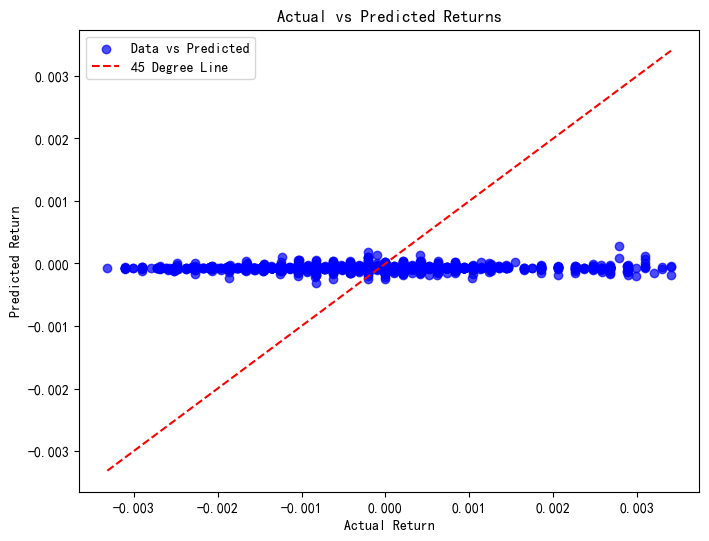

In [ ]:
# 选择因子和收益率列
X = table['factor3']  # 自变量（因子）
y = table['return']  # 因变量（收益率）

# 需要在 X 中加上常数项（截距）
X = sm.add_constant(X)

# 构建并拟合线性回归模型
model = sm.OLS(y, X)  # OLS = Ordinary Least Squares (最小二乘法)
results = model.fit()

# 输出回归结果
print(results.summary())  # 获取预测值
y_hat = results.fittedvalues  # 预测的收益率

# 绘制实际值与预测值的散点图
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制实际值和预测值的散点图
ax.scatter(y, y_hat, c='blue', label='Data vs Predicted', alpha=0.7)

# 绘制45度线（理想情况下，预测值等于实际值时，应该位于这条线）
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='45 Degree Line')

# 添加标签和标题
ax.set_xlabel('Actual Return')
ax.set_ylabel('Predicted Return')
ax.set_title('Actual vs Predicted Returns')

# 显示图例
ax.legend(loc='best')

plt.show()



In [73]:
correlation = table['factor3'].corr(table['return'])  # Pearson相关系数
print("因子与收益的相关性：", correlation)


因子与收益的相关性： 0.02200387517588146
